TP 2 - Echantillonnage compressif
==================

### Groupe: NGUYEN Minh Hai - LE Cam Thanh Ha - 4 GMM A

In [2]:
import numpy as np
import math
import scipy.fftpack as fft
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (8,6)
# plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
# plt.rcParams['figure.fontsize'] = 12

Récemment (début années 2004-présent), de nouveaux concepts et théorèmes ont été développés et risquent de 
révolutionner à relativement court terme la fabrication de certains appareils de mesure numériques (microphones, imageurs, analyseurs de spectres,...). 
Ces nouvelles techniques sont couramment appelées échantillonnage compressif, "compressive sampling" ou encore "compressed sensing". 

## 1. Le théorème de Shannon

Aujourd'hui, presque tous les appareils de mesure reposent sur le théorème de Shannon. Celui-ci (vous l'avez déjà vu en 2ème année) peut s'énoncer ainsi : 
> Soit $g:\mathbb{R}\to \mathbb{R}$ une fonction de $L^2(\mathbb{R})$. Si sa transformée de Fourier $\hat g$ a un support contenu dans l'intervalle $[-f_M, f_M]$, alors en l'échantillonnant à une fréquence d'échantillonnage $f_e\geq 2f_M$, on peut la reconstruire exactement.

Ce théorème est illustré sur les figures ci-après:
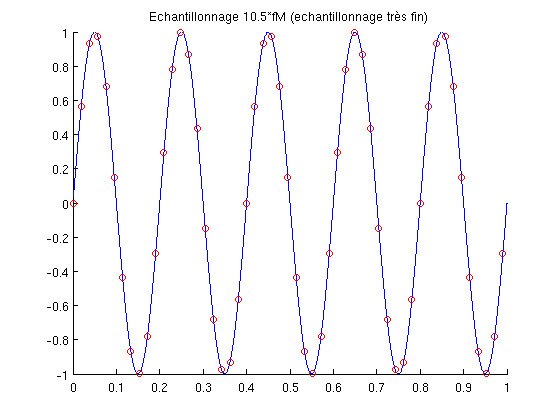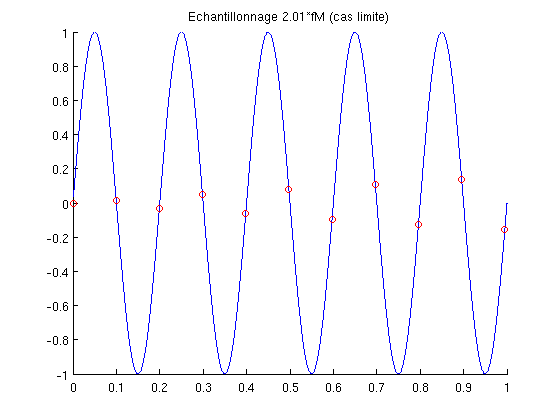
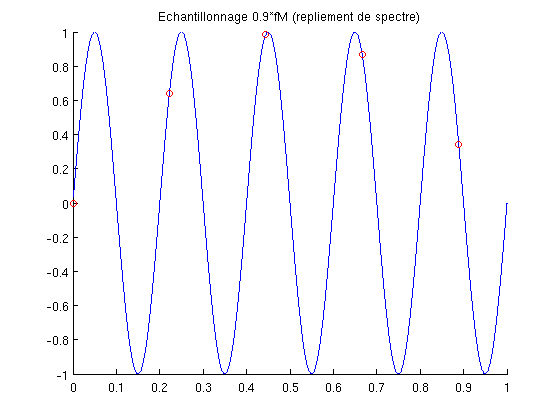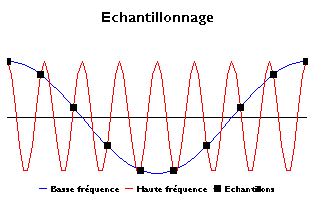

Les instruments de mesures qui reposent sur ce théorème sont donc construits suivant le principe : 
>Filtre passe-bas $\rightarrow$ Echantillonnage à une fréquence $f>2f_M$ $\rightarrow$ Interpolation sinc

Pour beaucoup d'applications, ce principe présente deux défauts majeurs :
* Les signaux sont rarement naturellement à spectre borné, et on perd donc l'information haute-fréquence en effectuant un filtrage passe-bas.
* Pour beaucoup de signaux, il faut choisir une très haute fréquence d'échantillonnage pour obtenir un résultat satisfaisant. 
Ceci implique que les données à stocker ont une taille très importante et qu'il faut les compresser après coup (par exemple : jpeg).




## 2. L'échantillonnage compressif

**1. Principe général**

L'idée sous jacente à l'échantillonnage compressif est de réaliser la compression dès l'acquisition.
Supposons que le signal $x\in \mathbb{R}^n$ que l'on souhaite mesurer s'écrive comme une combinaison linéaire de la forme :
\begin{equation}
(1)~~~~~~~~~~~ x=\sum_{i=1}^m\alpha_i \psi_i
\end{equation}
où $\psi_i\in \mathbb{R}^n, \ i=1..m$, sont des "fonctions de base" (en traitement d'images, ces fonctions pourraient être des ondelettes, en traitement du son, des ondelettes ou des atomes de Fourier, pour certaines applications, on pourrait imaginer des splines...} et $\alpha_i\in \mathbb{R}$ sont des coefficients. 
On peut réécrire l'équation (1) sous la forme matricielle condensée :
$$
x=\Psi \alpha \ \ \textrm{où } \ \ \alpha=\begin{pmatrix} \alpha_1 \\ \vdots \\ \alpha_m \end{pmatrix}\ \ \textrm{et} \ \ \Psi=\begin{pmatrix} \psi_1,\psi_2,..., \psi_m\end{pmatrix}.
$$
Pour pouvoir reconstruire tous les éléments de $\mathbb{R}^n$, on suppose généralement que la matrice $\Psi$ est une matrice surjective (ainsi, la famille  des $(\Psi_i)_i$ est génératrice), ce qui implique que $m\geq n$. Dans le langage du traitement d'image, on dit alors que $\Psi$ est un frame (une base si $m=n$).

L'échantillonnage compressif repose sur l'hypothèse suivante : les signaux $x$ que l'on souhaite mesurer sont parcimonieux, 
c'est-à-dire que la majorité des coefficients $\alpha_i$ dans (1) sont nuls ou encore que 
$$\#\{\alpha_i\neq 0, i=1..m\}\ll n.$$
On va voir que cette hypothèse permet - dans certains cas - de réduire drastiquement le nombre de mesures par rapport au théorème de Shannon avec en contre-partie, le besoin de résoudre un problème d'optimisation pour reconstruire la donnée. L'objectif de ce TP est de résoudre le problème d'optimisation résultant.

Le principe de l'acquisition du signal $x$ est le suivant :

- On effectue un petit nombre $p\ll n$ de mesures linéaires du signal $x$ inconnu. On note ces mesures $y_i$, et comme elles sont linéaires par rapport à $x$, il existe pour chaque $i$ un vecteur $a_i\in \mathbb{R}^n$ tel que 
$$y_i = \langle a_i, x  \rangle, i=1..p.$$ 
On peut aussi écrire cette opération de mesure sous la forme condensée :
$$
y=Ax\ \ \textrm{où } \ \ y=\begin{pmatrix} y_1 \\ \vdots \\ y_p\end{pmatrix} \ \ \textrm{et} \ \ A=\begin{pmatrix} a_1^T\\a_2^T\\ \vdots
\\ a_p^T\end{pmatrix}.
$$
- On reconstruit le signal $x$ en résolvant le problème contraint suivant :

$$
(2)~~~~~~~~~~~ \text{Trouver } \alpha^\star \text{ solution de: }\displaystyle\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_0
$$

où $\|\cdot\|_0$ est la norme de comptage, aussi appelée norme $l^0$ définie par : 
$$
\|\alpha\|_0=\#\{\alpha_i\neq 0, i=1..m\}.
$$
Autrement dit, l'idée est la suivante : on  cherche $\alpha^\star$, le signal le plus parcimonieux dans le frame $\Psi$, parmi les signaux qui peuvent donner lieu aux mesures $y$. 
Après avoir trouvé $\alpha^\star$, on recouvre $\tilde x$, une approximation du signal $x$ en calculant $\tilde x=\Psi\alpha^\star$.



**2. Simplification du problème d'optimisation**

Le problème précédent est un problème combinatoire NP-complet, ce qui signifie que trouver $\alpha$ peut demander un temps exponentiel en fonction de $n$, la dimension du signal. Pour le résoudre en pratique, il est souvent remplacé par : 

$$
(3)~~~~~~~~~~~  \text{Trouver } \alpha^*\in \displaystyle\arg\min_{\alpha \in \mathbb{R}^m, A\Psi\alpha=y} \|\alpha\|_1
$$

où $\|\alpha\|_1=\sum_{i=1}^m|\alpha_i|$ est la norme $l^1$ de $\alpha$. On peut dans certains cas montrer que les solutions de (2) et de (3) sont identiques. 

Un appareil de mesure n'étant jamais parfait, il est impossible de mesurer exactement $y_i=\langle a_i, x\rangle$. 
Le vecteur $y$ est bruité et la contrainte $A\Psi\alpha=y$ est trop forte. Elle est donc généralement relaxée et le problème devient : 

>$$(4)~~~~~~~~~~~  \text{Trouver } \alpha^*\in \arg\min_{\alpha \in \mathbb{R}^m} \|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.$$

Si $\sigma$ tend vers $0$, la solution du problème (4) tend vers une solution du problème (3). C'est le problème (4) que nous allons résoudre dans ce TP. Dans la suite , on notera $F$ la fonction :
$$
F(\alpha)=\|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.
$$

On peut remarquer que les problèmes (3) et (4) sont convexes (contraintes convexes et fonctions convexes) tandis que le problème (2) ne l'est pas. En revanche, aucun des trois problèmes n'est différentiable.

Pour conclure cette introduction à l'échantillonnage compressif, notons que de façon similaire au théorème de Shannon, on dispose d'une condition de reconstruction exacte :

> Supposons que :
* $x=\displaystyle\sum_{i=1}^m\alpha_i\psi_i\in \mathbb{R}^n$ avec $\|\alpha\|_0=k$.
* On effectue $p$ mesures linéaires de $x$ avec $p\geq C \cdot k \cdot \log(n)$, où $C=20$.
* On choisit les coefficients de la matrice $A\in \mathcal{M}_{p,n}$ de façon **aléatoire** (e.g. on peut choisir les coefficients $a_{i,j}$ de $A$ de façon indépendante suivant une loi normale.)

> Alors, la résolution du problème (3) permet de reconstruire $x$ **exactement** avec une très grande probabilité 

L'expérience a montré qu'en pratique, il suffit en général de $p=2k$ mesures pour reconstruire le signal exactement en grande dimension !

### 4. Algorithme Forward Backward

Commencons par quelques rappels: soit $F=f+g$ une fonction convexe composite avec $f$ différentiable à gradient 
$L$-Lipschitz et $g$ une fonction convexe dont on sait calculer l'opérateur proximal. L'algorithme Forward-Backward s'écrit alors:
$$x_{k+1}=prox_{sg}(x_k-s\nabla f(x_k)).$$

On peut montrer que la suite $(F(x_k)-F(x^*))_{k\in \mathbb N}$ est décroissante et: 
$$F(x_k)-F(x^*)\leqslant \frac{2\Vert x_0-x^*\Vert^2}{sk}$$
Cette vitesse en $\frac{1}{k}$ est optimale au sens où il n'est pas possible de trouver des bornes qui décroissent en $\frac{1}{k^{\delta}}$ avec $\delta>1$ pour toutes les fonctions convexes. On peut montrer que si $s<\frac{1}{L}$ on a en fait 
$$F(x_k)-F(x^*)=o\left(\frac{1}{k}\right).$$

Revenons maintenant au problème (4) et appliquons l'algorithme FB pour le résoudre. Pour cela: 

**Q1.** Soit $J(\alpha) =\frac{\sigma}{2}\|A\Psi \alpha - y\|_2^2$. Calculez $\nabla J(\alpha)$.



    

<span style="color:green"> Réponse: \
Remarquons que la fonction $J : \mathbb{R}^m \rightarrow \mathbb{R}$ est différentiable sur $\mathbb{R}^m$. De plus, elle est composée d'une carré de norme $l_2$ et d'une fonction affine. Donc son gradient vaut 

$$\color{green}{\nabla J(\alpha) = \sigma (A\Psi)^T (A \Psi \alpha - y ) =  \sigma \Psi^T A^T (A \Psi \alpha - y )}$$

</span>

**Q2.** Montrer que la fonction $J$ est de classe $C^1$ à gradient Lipschitz et calculer un majorant $L$ de la constante de Lipschitz de $\nabla J$ en fonction de $|||A|||$, de $|||\Psi |||$ et de $\sigma$.

<span style="color:green"> Evidemment, $J$ est de classe $C^1$ à gradient Lipschitz car $J$ est composée des fonctions de classe $C^1$, précisement la carré d'une norme $||.||_2$ et la fonction affine $A \Psi \alpha - y$

<span style="color:green"> Calculons maintenent le majorant $L$ de la constante de Lipschitz de $\nabla J$

$\begin{align*}
\color{green} ||\nabla J(\alpha_1) - \nabla J(\alpha_2)|| &\color{green}= \color{green}||\sigma \Psi^T A^T (A \Psi \alpha_1 - y ) - \sigma \Psi^T A^T (A \Psi \alpha_2 - y )|| \\
&\color{green}= \color{green} ||\sigma \Psi^T A^T A \Psi(\alpha_1-\alpha_2)||\\
& \color{green}\leqslant \color{green} \sigma ||\Psi^T A^T A \Psi|| ||\alpha_1 - \alpha_2||
\end{align*}
$
<span style="color:green"> Par définition, on identifie $L = \sigma ||\Psi^T A^T A \Psi||$

<span style="color:green"> Particulièrement, $\Psi \Psi^T = [I|C]\left[\dfrac{I}{C^T}\right ] = I + CC^T = 2I$ 

<span style="color:green">d'où $||\Psi\Psi^T||=2$ et alors $L \leqslant 2 \sigma ||A^T A || = 2\sigma ||A||^2$
</span>

**Q3.** On note $\alpha^k$ l'itéré courant. On veut utiliser l'algorithme Forward-Backward pour la résolution du problème (4) en choisissant un pas constant égal à $\frac{1}{L}$. Ecrire une itération de l'algorithme FB et donner la formule analytique permettant de calculer
$\alpha^{k+1}$ en fonction de $\alpha^k$.


<span style="color:green"> Notons $F(\alpha) = f(\alpha) + J(\alpha)$ avec $f(\alpha)=\|\alpha\|_1$ et $J(\alpha) = \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2$ \
On sait que $f$ est une fonction convexe (car une norme), s.c.i (car continue), differentiable sur $\mathbb{R}^m$ sauf en $0$ et on est capable de calculer son opérateur proximal, et $J$ est une fonction convexe, différentiable (la carré de la norme $l_2$) et à gradient $L-$ Lipschitz. \
Donc notre problème satisfait toutes les hypothèses de l'algorithme Forward-Backward
</span>

<span style="color:green">
Une itération de l'algorithme Forward-Backward s'écrit

$$ \alpha^{k+1} = \text{prox}_{sf} (\alpha^k - s \nabla J(\alpha ^k)) $$

Supposons que $x = (x_1, x_2, ..., x_m) \in \mathbb{R}^m$, alors d'après un résultat du cours (cf. TD2), on a

$$\text{prox}_{sf}(x) = \left(\text{sign}(x_1) \max (|x_1| - s, 0), \text{sign}(x_1) \max (|x_2| - s, 0), ..., \text{sign}(x_1) \max (|x_m| - s, 0) \right)$$

Ainsi, en notant la partie "Forward" $\beta^k =  \alpha^k - s \nabla J(\alpha ^k)$, on obtient

\begin{align*}
\alpha^{k+1} &= \text{prox}_{sf} (\alpha^k - s \nabla J(\alpha ^k)) \\
            &= \text{prox}_{sf} (\beta^k) \\
            &= \left(\text{sign}(\beta^k_1) \max (|\beta^k_1| - s, 0), \text{sign}(\beta^k_2) \max (|\beta^k_2| - s, 0), ..., \text{sign}(\beta^k_m) \max (|\beta^k_m| - s, 0) \right)
\end{align*}

**Remarque:** Nous pouvons considerer le calcul de cet opérateur proximal (ou encore une itération de l'algorithme FB) comme le coeur de ce problème de Compressive Sensing. Nummériquement, ce calcul repose juste sur les opérateurs élémentaires comme le max, la signe et les produits terme à terme, tous ces opératios sont implémentées de manière très efficace en Numpy. Donc, dans ce cas notre problème dépend faiblement de la dimension du problème et nous pourrions lancer cet algorithme en beaucoup d'itérations, de 10 milles voire 100 milles, ce qui est un bon signe car nous n'avons pas encore l'accès à vitesse de convergence. 

</span>


**Q4.** De quelle quantité la fonction coût $F(\alpha)$ décroît-elle à chaque itération ?

<span style="color:green">

Nous allons dans cette partie étudier la suit $ \left( F(\alpha^k) - F(\alpha^{k+1}) \right)_k $. Avec les notation définies précedament, i.e $F(\alpha) = f(\alpha) + J(\alpha)$, une itération de l'algorithme FB s'écrit

$$\alpha^{k+1} = \text{prox}_{sf} (\alpha^k - s \nabla J(\alpha ^k))$$

Equivalent à
$$ \alpha^k - s \nabla J(\alpha ^k) - \alpha^{k+1} \in s \partial f(\alpha^{k+1})$$

Ainsi, pour tout $\alpha \in \mathbb{R}^m$, on a:  
$$sf(\alpha) \geqslant sf(\alpha^{k+1}) + \langle \alpha^k - s\nabla J(\alpha ^k) - \alpha^{k+1}, \alpha - \alpha^{k+1} \rangle$$

Pour $\alpha = \alpha^k$, on obtient:
$$sf(\alpha^k) \geqslant sf(\alpha^{k+1}) + \langle \alpha^k - s\nabla J(\alpha ^k) - \alpha^{k+1}, \alpha^k - \alpha^{k+1} \rangle$$
ou
\begin{align*}
sf(\alpha^k) - sf(\alpha^{k+1}) & \geqslant \langle \alpha^k - s\nabla J(\alpha ^k) - \alpha^{k+1}, \alpha^k - \alpha^{k+1} \rangle \\
    & = \lVert \alpha^k - \alpha^{k+1} \rVert ^2 - s \langle \nabla J (\alpha ^k), \alpha^k - \alpha^{k+1} \rangle
\end{align*}
Donc
$$ f(\alpha^{k+1}) - f(\alpha^{k}) \leqslant \langle \nabla J (\alpha ^k), \alpha^k - \alpha^{k+1} \rangle - \frac{1}{s} \lVert \alpha^k - \alpha^{k+1} \rVert ^2 $$

Comme $J$ est à gradient L-Lipschitz, par définition, on a:
$$J(\alpha^{k+1}) \leqslant J(\alpha^k) + \langle \nabla J(\alpha^k), \alpha^{k+1} - \alpha^{k} \rangle + \frac{L}{2} \lVert \alpha^{k+1} - \alpha^{k} \rVert^2$$

ou 
$$J(\alpha^{k+1}) - J(\alpha^k) \leqslant  \langle \nabla J(\alpha^k), \alpha^{k+1} - \alpha^{k} \rangle + \frac{L}{2} \lVert \alpha^{k+1} - \alpha^{k} \rVert^2$$

En sommant ces deux dernières inégalités et remarquons que $F(\alpha) = f(\alpha) + J(\alpha)$, on obtient

$$F(\alpha^{k+1}) - F(\alpha^k) \leqslant  \left(\frac{L}{2} - \frac{1}{s} \right)  \lVert \alpha^{k+1} - \alpha^{k} \rVert^2$$
</span>

<span style="color:red">

Remarque: on peut constater que si $s < \frac{2}{L}$, l'algorithme de Forward-Backward est un algorithme de descent.

</span>

#### 4.1 Partie expérimentale. Les données
------------------------

Dans ce TP, on va chercher à reconstruire un signal unidimensionnel $x~:~[0,1]~\rightarrow~\mathbb{R}$ de la forme :
$$
x(t)= \alpha_{k}\delta_{k/n}(t)+\sum_{k=1}^n\alpha_{k+n}\cos\left(\frac{2k\pi}{n} t\right)
$$ 
on a donc $m=2n$.

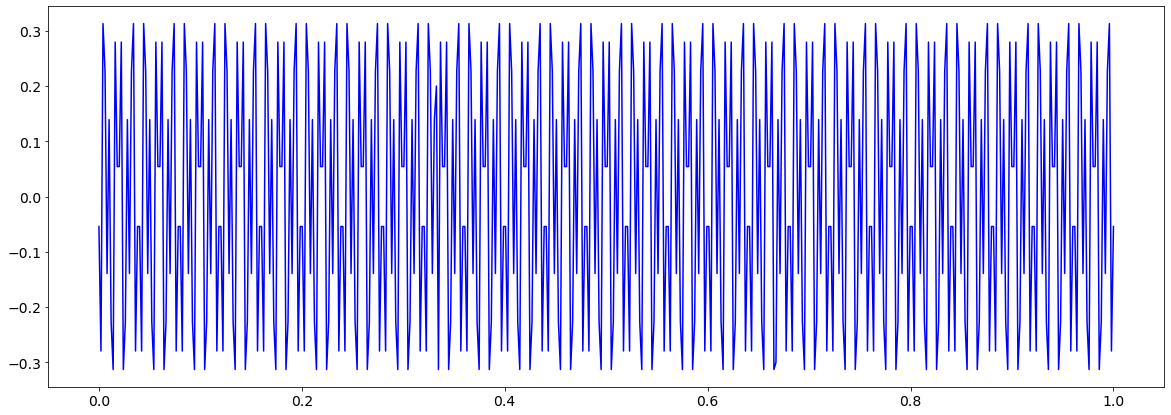

In [4]:
## Initialisations
n = 500            # Taille de l'echantillon
t = np.linspace(0,1,n) # On definit un signal sur [0,1]

## Generation du signal
x = np.zeros(n)
tmp = np.zeros(n)
# On ajoute deux cosinus
tmp[350] = 4
x += fft.idct(tmp,norm='ortho')  
tmp = np.zeros(n)
tmp[150] = -3  
x += fft.idct(tmp,norm='ortho')

# On ajoute deux diracs
x[int(n/3)] = 0.2;    # Tester 0.5
x[int(2*n/3)] = -0.3; # Tester -1

plt.figure(figsize=(20,7))
plt.plot(t,x,'b')

# plt.xlim([0,0.2])
plt.show()

## Mesure du signal
p = 20*4       # Nombre de mesures
A = np.random.randn(p,n) # La matrice de mesure
y = A.dot(x)        # Les mesures

Le code *Generesignal.py* génère un signal discret $x$ qui peut être vu comme une combinaison linéaire de cosinus à différentes fréquences et de diracs. Ce signal n'est pas parcimonieux dans la base canonique des diracs (car il faut à peu près $n$ diracs pour représenter un cosinus) et il n'est pas parcimonieux dans la base des sinus (il faut faire une combinaison linéaire de $n$ cosinus pour représenter un dirac).

Par contre, ce signal est parcimonieux dans un frame qui est l'union de la base canonique et de la base des cosinus. 
Dans ce frame, il suffit en effet de $4$ coefficients non nuls pour reconstruire parfaitement le signal.

> On choisira donc le frame représenté par une matrice $\Psi=(I,C) \in \mathcal{ M}_{2n,n}(\mathbb{R})$ o\`u $C$ est une base de cosinus à différentes fréquences.

#### 4.2. Implémentation de l'itération proximale

**Q5** Implémentez l'opérateur linéaire $\Psi$ et son adjoint $\Psi^*$. 

Pour $\Psi$, vous vous servirez de la fonction $dct$ de Python dans la libraire scipy.fftpack qui calcule la transformée en cosinus discret d'un vecteur. Vous ferez attention à préciser *norm='ortho'* dans les options de la $dct$ pour que $idct$ soit bien l'opération inverse de $dct$.

Pour $\Psi^*$, vous utiliserez le fait que la $dct$ est une isométrie quand on précise $\textit{norm='ortho'}$ dans les options de $dct$.

In [7]:
## Linear function Psi
## (combination of sines and diracs) 
def Psi(alpha) :
    '''
    Fonction calcule x = Psi alpha
    '''
    n = int(len(alpha)/2)
    x = alpha[:n] # I.alpha
    x = x + fft.idct(alpha[n:], norm='ortho') 

    return x


## The transpose of Psi
def PsiT(x) : 
    '''
    Fonction calcule alpha = Psi*x
    '''
    n = len(x)
    alpha = np.zeros(2*n)
    alpha[:n] = x
    alpha[n:] = fft.dct(x, norm='ortho') 
    return alpha

**Q6** Implémentez l'algorithme proximal dans la fonction *RestoreX* avec les notations suivantes:
* $A$ est la matrice d'échantillonnage.
* $y$ est le vecteur de mesures.
* $sigma$ est un paramètre du modèle.
* $nit$ est le nombre d'itérations.
* $alpha$ est la solution approximative du problème (4).
* $x$ est donné par Psi $(\alpha)$.
* $CF$ est la fonction coût à chaque itération de l'algorithme. 

On définit ci-dessous une fonction permettant calculer la fonction coût 
$$
F(\alpha)=\|\alpha\|_1 + \frac{\sigma}{2} \|A\Psi\alpha-y\|_2^2.
$$


In [6]:
def F(alpha, sigma, A = A, y = y):
    return np.abs(alpha).sum() + 0.5*sigma*np.linalg.norm(A.dot(Psi(alpha)) - y)**2

In [8]:
## Prox of the l1−norm 
def prox(alpha,gamma) :
    '''
    Prox of L1 norm
    Inputs: alpha - dim 2*n
            gamma - float
    Return the prox operator of gamme|x|
    ''' 
    prox = np.sign(alpha)*np.maximum(np.abs(alpha) - gamma, 0)
    return prox

def RestoreX(A, y, sigma, alpha_init, niter_max): 
    '''
    Optimisaton process for recovering the original signal
    Input:  niter_max - number of iterations
            A - Sampling matrix, of shape p x n where p is number of samples, n is signal dimension
            sigma - Parameter of optim problem
            y - samples, of shape (p,)

    '''
    alpha = alpha_init # Solution of optim probleme
    CF = [F(alpha, sigma)] # List to store loss function over optimisation process
    list_alpha = [alpha]

    # Calculate the gradient-Lipschitz constant approx., also used as the pas de descente
    L = 2.*sigma*np.linalg.norm(A)**2   # We are using norm 2 for matrix norm
    s = 1/L
    
    for i in range(niter_max):
        grad = sigma*PsiT(A.T.dot(A.dot(Psi(alpha)) - y))
        alpha = prox(alpha - s*grad, s)
        list_alpha.append(alpha)
        CF.append(F(alpha, sigma))

    x = Psi(alpha) # Reconstructed signal from our algorithm

    return [np.array(list_alpha), x, CF] 


**Q7.** Testez votre algorithme ! Les paramètres $sigma$ et $nit$ sont des à choisir par vous-même (il faut en pratique beaucoup d'itérations pour converger). Vous pourrez observer la façon dont la suite $\alpha^k$ se comporte au fur et à mesure des itérations.

<span style="color:green">

Tout d'abord, on va inplémenter la méthode Forward-Backward sous forme d'une `class` (ou encore `dashbord`) pour simplifier l'utilisation

<span>

In [9]:
class CompressiveSensing(object):
    '''
    Class for ForwardBackward algorithm
    '''
    def __init__(self, A, y, sigma, alpha_init, niter_max = 10000, method = 'FB'):
        self.A = A
        self.y = y
        self.sigma = sigma
        self.alpha_init = alpha_init   
        self.niter_max = niter_max

        self.loss_history = []
        self.alpha_history = []
        self.xtilde = None
        L = 2.*sigma*np.linalg.norm(A)**2   # We are using norm 2 for matrix norm
        self.s = 1/L
        self.method = method
    


    def plot_result(self):
        fig, axs = plt.subplots(2, 2, figsize = (20,15), constrained_layout=True)

        axs[0,0].plot(self.alpha_history[-1])
        axs[0,0].set_title(r'$\alpha$ obtenu')
        axs[0,0].set_xlabel('Temps')
        axs[0,0].set_ylabel('Alpha')

        axs[0,1].plot(self.loss_history)
        axs[0,1].set_title(r'Evolution de fonction coût')
        axs[0,1].set_xlabel('Itération')
        axs[0,1].set_ylabel('Loss')

        axs[1,0].plot(self.xtilde)
        axs[1,0].set_title(r'Signal reconstruit')
        axs[1,0].set_xlabel('Temps')
        axs[1,0].set_ylabel(r'$x$')

        axs[1,1].plot(x - self.xtilde)
        axs[1,1].set_title(r'Erreur')
        axs[1,1].set_xlabel('Temps')
        axs[1,1].set_ylabel(r'$x - \hat{x}$')
        fig.suptitle(r'Résultats avec $\sigma = $ ' + str(self.sigma) + 
                ' et ' + str(self.niter_max) + ' itérations - ' + str(self.method), fontsize=30)
        plt.show()

    def plot_alpha(self):
        plt.plot(self.alpha_history[-1])

    def plot_loss(self):
        plt.plot(self.loss_history)
        plt.title(r'Evolution de fonction coût ' + str(self.method))
        plt.xlabel('Itération')
        plt.ylabel('Fonction coût')
    
    def comportement(self, alpha_star):
        difference = []
        for alp in self.alpha_history:
            difference.append(np.linalg.norm(alp - alpha_star))

        plt.plot(difference)
        plt.title(r'Comportement de $\alpha$ ' +str(self.method))
        plt.xlabel('Itération')
        plt.ylabel(r'$\| \alpha - \alpha^* \|$')
        plt.show()

    def CVrate(self, alpha_star):
        rate = self.loss_history - F(alpha_star, self.sigma)
        rate = rate*self.s/(2*np.linalg.norm(self.alpha_init - alpha_star)**2)
        self.rate = rate
        arr = np.arange(1,self.niter_max + 2)
        
        plt.plot(arr, np.log(rate), label = r'$\frac{s(F(\alpha) - F(\alpha^*))}{2 \| \alpha - \alpha^* \|}$')
        plt.plot(arr, np.log(1./arr), label = r'$\frac{1}{k}$')
        plt.plot(arr, np.log(1./arr**2), label=r'$\frac{1}{k^2}$')
        plt.title(r'Taux de convergence ' + str(self.method))
        plt.xlabel('Itération')
        plt.ylabel('log')
        plt.legend()
        plt.show()


In [10]:
class ForwardBackward(CompressiveSensing):
    def __init__(self, A, y, sigma, alpha_init, niter_max = 10000):
        super().__init__(A, y, sigma, alpha_init, niter_max)

    def Restore(self):
        '''
        Optimisation process
        '''
        self.alpha_history, self.xtilde, self.loss_history = RestoreX(self.A, self.y, self.sigma, self.alpha_init, self.niter_max)
        


<span style="color:green">

Pour avoir une comparaison juste entre plusieurs méthodes, nous allos ici initialiser les points de départ de l'algorithme en 2 façons: zeros et aléatoire
<span>

In [11]:
zeros_init = np.zeros(2*n)
random_init = np.random.rand(2*n)

In [36]:
FB1 = ForwardBackward(A, y, sigma = 0.1, alpha_init = zeros_init, niter_max=20000)
FB1.Restore()
FB2 = ForwardBackward(A, y, sigma = 0.1, alpha_init = random_init, niter_max=20000)
FB2.Restore()

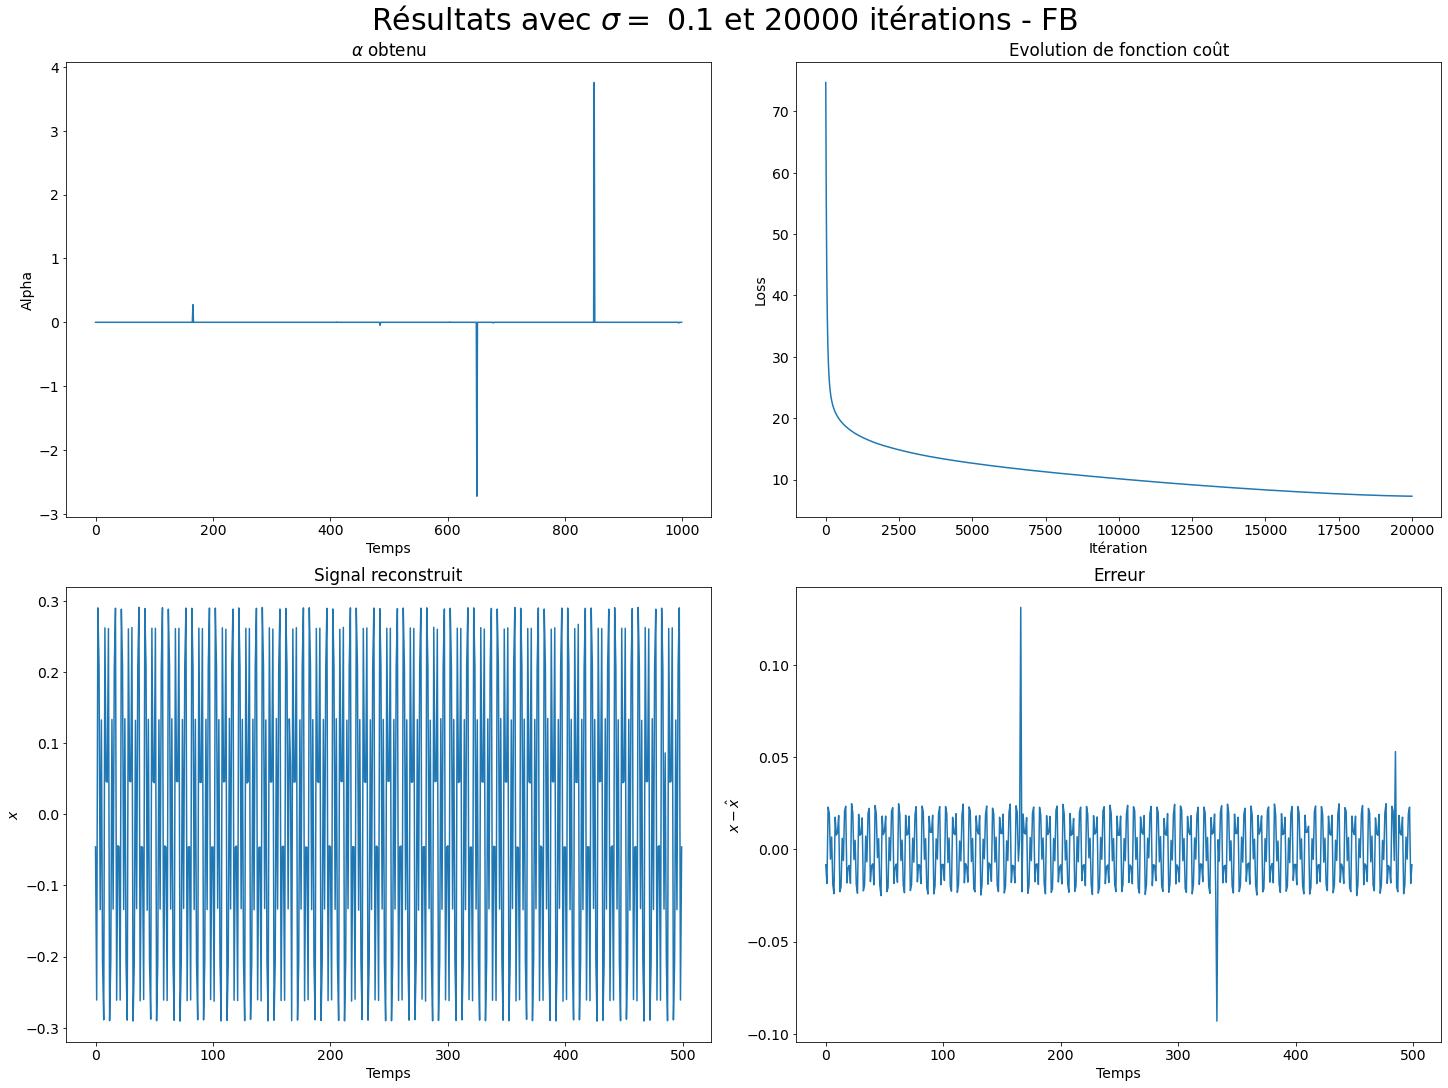

In [13]:
FB1.plot_result()

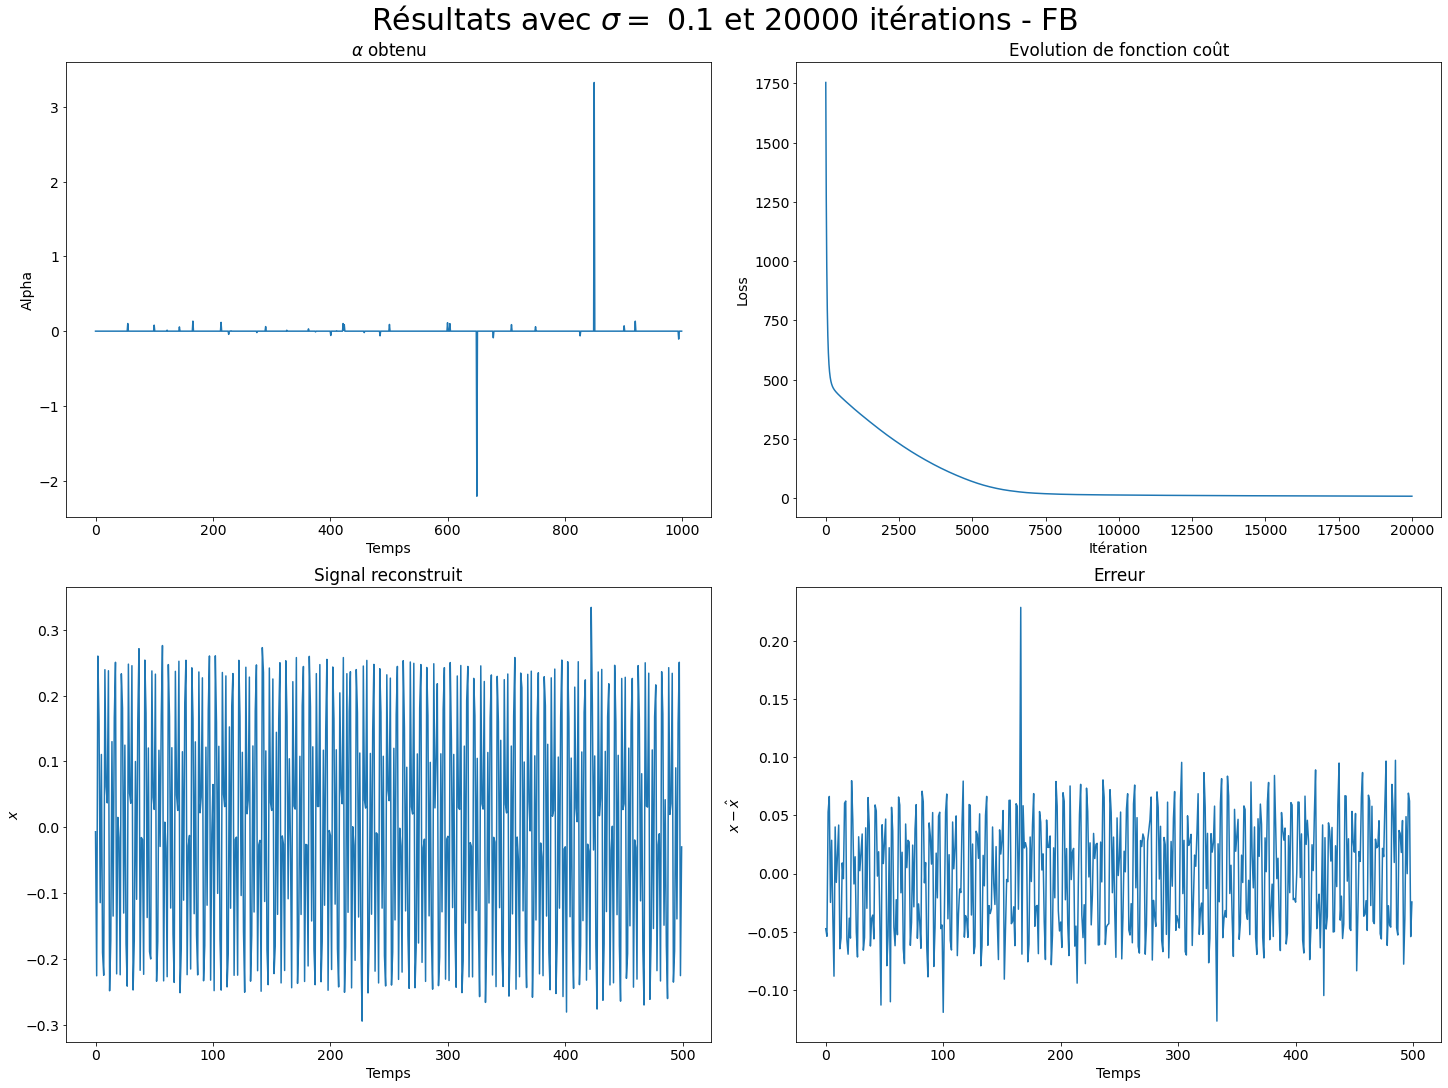

In [37]:
FB2.plot_result()

<span style="color:green">
Clairement par les graphes, dans la suite, c'est mieux d'utiliser le point de départ de zéro.
<span>

<span style="color:green"> Cherchons maintenant la valeur optimale de sigma. 

In [39]:
sigmas = np.linspace(0, 10, 10) 
erreur_norm = []

for sigma in sigmas:
    FB_sigma = ForwardBackward(A, y, sigma, alpha_init = zeros_init, niter_max = 10000)
    FB_sigma.Restore()
    erreur_norm.append(np.linalg.norm(x - FB_sigma.xtilde))

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/2199028974.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  self.s = 1/L
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/3345266194.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  s = 1/L
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/3345266194.py:31: RuntimeWarning: invalid value encountered in multiply
  alpha = prox(alpha - s*grad, s)


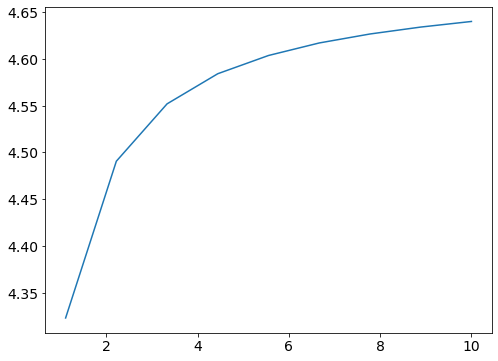

In [40]:
plt.plot(sigmas, erreur_norm)

<span style="color:green"> Facilement noté que plus sigma est petit, meilleur résultat est obtenu. Testons les petites valeurs de sigma

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/2199028974.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  self.s = 1/L
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/3345266194.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  s = 1/L
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/3345266194.py:31: RuntimeWarning: invalid value encountered in multiply
  alpha = prox(alpha - s*grad, s)


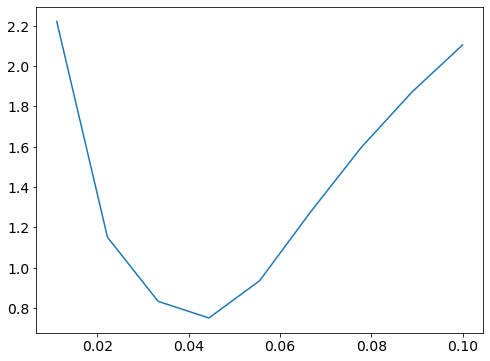

In [43]:
sigmas = np.linspace(0, 0.1, 10) 
erreur_norm = []

for sigma in sigmas:
    FB_sigma = ForwardBackward(A, y, sigma, alpha_init = zeros_init, niter_max = 10000)
    FB_sigma.Restore()
    erreur_norm.append(np.linalg.norm(x - FB_sigma.xtilde))
plt.plot(sigmas, erreur_norm)

In [50]:
iters = np.linspace(10000,100000,10)
sigmas = np.linspace(0, 0.1, 10) 
erreur_norm = []
for sigma in sigmas:
    for it in iters:
        FB_sigma = ForwardBackward(A, y, sigma, alpha_init = zeros_init, niter_max = int(it))
        FB_sigma.Restore()
        erreur_norm.append(np.linalg.norm(x - FB_sigma.xtilde))
plt.contour(iters,sigmas,erreur_norm)

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/2199028974.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  self.s = 1/L
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/3345266194.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  s = 1/L
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_8304/3345266194.py:31: RuntimeWarning: invalid value encountered in multiply
  alpha = prox(alpha - s*grad, s)


## Comportement de $\alpha$ durant l'optimisation (à chaque itération)

On peut considerer que la solution de l'algorithme FB avec un très grand nombre d'itération comme une approximation de $\alpha^*$ et on regarde le comportement des $\alpha_k$ par rapport à cette $\alpha^*$

On définit $\alpha^*$ comme le résultat de l'algorithme FB avec $100 000$ itérations et $\sigma = 0.5$

In [14]:
FB_star = ForwardBackward(A, y, sigma = 0.1, alpha_init = zeros_init, niter_max=100000)
FB_star.Restore()
alpha_star = FB_star.alpha_history[-1]

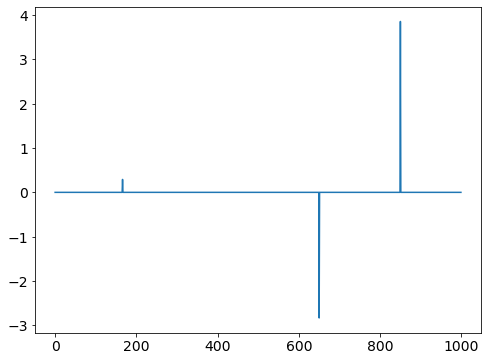

In [15]:
plt.plot(alpha_star)

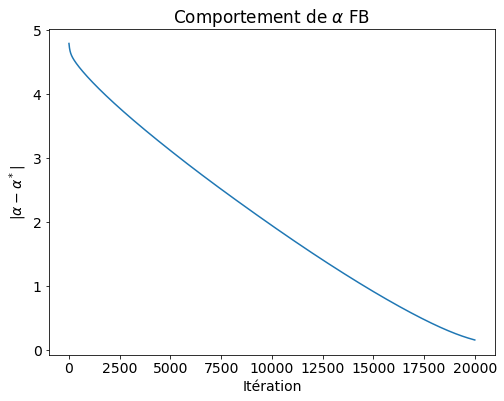

In [16]:
FB1.comportement(alpha_star)

**Q8.** Vérifiez que la fonction coût décroit de façon monotone. Quel est le taux de convergence observé ?

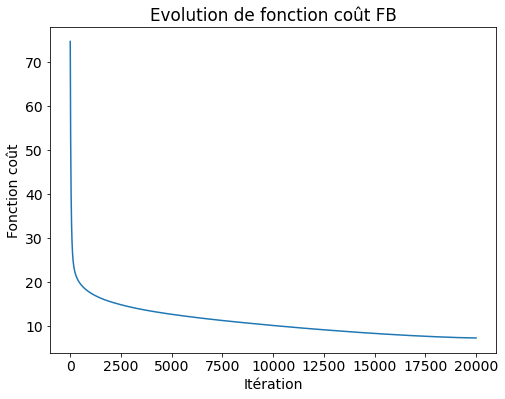

In [18]:
FB1.plot_loss()

<span style="color:green"> On peut constater que la fonction coût décroit très vite dans les premières itérations, après elle descent peu de temps en temps en fonction des iterations.

<span style="color:green"> Observons le taux de convergence par le graphe ci-dessous

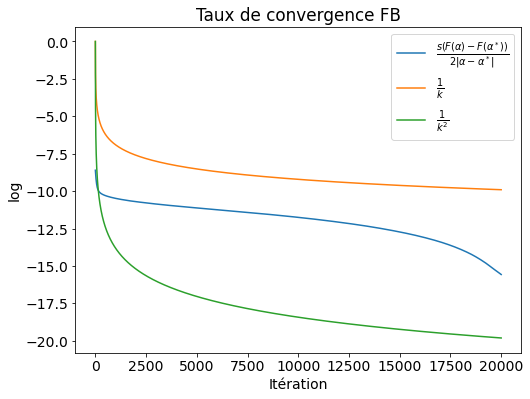

In [28]:
FB1.CVrate(alpha_star)

<span style="color:green">

Rappelons que le taux de convergence est bien $\frac{s(F(\alpha_k)-F(\alpha^*))}{2\Vert \alpha_0-\alpha^*\Vert^2}$

Par le graphe ci-dessus, c'est évident que la courbe representant ce taux est dessous $\frac{1}{k}$ mais dessus $\frac{1}{k^2}$. C'est-à-dire la vitesse de convergence est plus rapide que linéaire mais plus lente que quadratique.

Le taux de convergence est bien déduit $\frac{1}{k}$. Cette vitesse en $\frac{1}{k}$ est optimale au sens où il n'est pas possible de trouver des bornes qui décroissent en $\frac{1}{k^{\delta}}$ avec $\delta>1$. Si $s<\frac{1}{L}$ on a en fait 
$$F(\alpha_k)-F(\alpha^*)=o\left(\frac{1}{k}\right).$$
</span>

**Q9.** A partir de combien de mesures pouvez-vous reconstruire exactement le signal $x$ ?

In [ ]:
## Mesure du signal
for i in range(1,50):
    p = i*4       # Nombre de mesures
    A = np.random.randn(p,n) # La matrice de mesure
    y = A.dot(x)        # Les mesures

### 4.2. Implémentation de l'itération proximale accelérée

On n'a a aucun moment utilisé la convexité de la fonction $J$ pour définir l'algorithme proximal. Celui-ci est de fait sous-optimal et peut être nettement accéléré. Yuri Nesterov a proposé dans les années 1980 plusieurs méthodes permettant l'accélération de la descente de gradient explicite. L'accélération de la descente de gradient proposée Yurii Nesterov en 1984 et adapatée à FB sous le nom de FISTA (Fast Iterative Soft Shrinckage Algorithm) par Beck et Teboulle en 2009 est d'une mise en oeuvre très simple: considérons à nouveau la fonction composite $F=f+g$ à minimiser. L'algorithme FISTA s'écrit:
\begin{equation}
y_k = x_k+\alpha_k(x_k-x_{k-1})\text{ et }  
x_{k+1} = {\rm prox}_{sg}(y_k-s\nabla f(x_k))
\end{equation}

avec un pas $s<\frac{1}{L}$ et $\alpha_k>0$. On parle de méthode inertielle car cette méthode utilise un terme dit de "mémoire" ou inertiel qui exploite la dernière direction de descente.

Le choix original de Nesterov pour la suite $\alpha_k$ est le suivant :
\begin{equation}
\alpha_k=\frac{t_k-1}{t_{k+1}}\text{ avec }t_1=1\text{ et }t_{k+1}=\frac{1+\sqrt{1+t_k^2}}{2}
\end{equation}
Pour ce choix on a 
$$F(x_k)-F(x^*)\leqslant \frac{2\Vert x_0-x^*\Vert^2}{sk^2}$$
On peut prendre plus simplement $$\alpha_k=\frac{k-1}{k+2}$$ et dans ce cas, on a $F(x_k)-F(x^*)=o\left(\frac{1}{k^2}\right)$ et on a convergence de la suite $(x_k)_{k\geqslant 1}$. On peut noter que dans ce cas, la première étape est sans inertie ($\alpha_1=0$) et donc $x_1=T(x_0)$. L'inertie apparait pour le calcul de $x_2$. 

A noter que la suite de terme général $F(x_k)-F(x^*)$ n'est pas nécessairemment décroissante comme dans le cas de FB ou de la descente de gradient. Dans la pratique vous verrez que FISTA est quand même plus rapide que FB.

 
**Q10.** En vous aidant de ce que vous avez codé dans la partie précédente, implémentez cet algorithme. 

In [19]:
def Nesterov(A, y , sigma, alpha_init, niter_max):
    n = A.shape[1]  
    alpha_old = alpha_init
    
    # Calculate the gradient-Lipschitz constant approx., also used as the pas de descente
    L = 2*sigma*np.linalg.norm(A)**2   # We are using norm 2 for matrix norm
    s = 1/L

    # First iteration
    grad = sigma*PsiT(A.T.dot(A.dot(Psi(alpha_old)) - y))
    alpha = prox(alpha_old - s*grad, s)
    list_alpha = [alpha_old, alpha]
    CF = [F(alpha_old, sigma), F(alpha, sigma)]   
    for k in range(2,niter_max+1):
        coef = (k - 1)/(k + 2)
        y_nesterov = alpha + coef*(alpha - alpha_old)
        grad = sigma*PsiT(A.T.dot(A.dot(Psi(alpha)) - y))
        alpha_old = alpha
        alpha = prox(y_nesterov - s*grad, s)
        list_alpha.append(alpha)

        CF.append(F(alpha, sigma))
        
    x = Psi(alpha)

    return np.array(list_alpha), x, CF

**Q12.** Testez le et comparez la rapidité d'execution de l'algorithme précédent et de celui-ci.

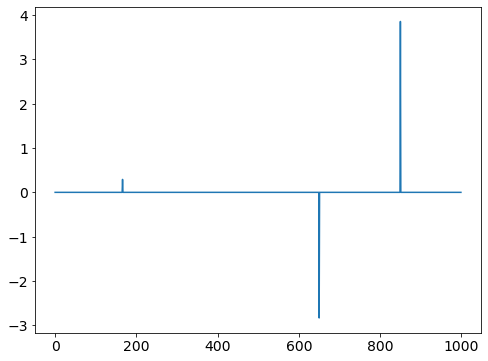

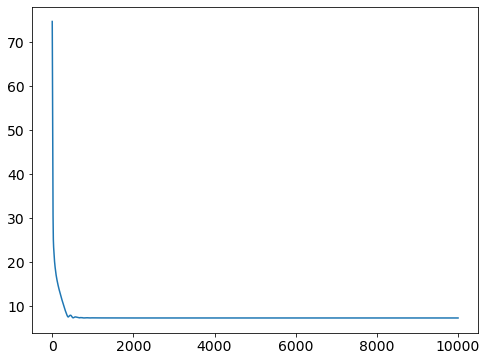

In [20]:

list_alpha_nest, x_nest, CF_nest = Nesterov(A, y, sigma = 0.1, alpha_init = zeros_init, niter_max = 10000)
plt.plot(list_alpha_nest[-1])
plt.show()
plt.plot(CF_nest)
plt.show()

On a créer une ``classe` pour cette méthode d'accélération pour faciliter les comparaisons et expérimentations

In [21]:
class NesterovAcc(CompressiveSensing):
    def __init__(self, A, y, sigma, alpha_init, niter_max = 10000, method = 'Nesterov'):
        super().__init__(A, y, sigma, alpha_init, niter_max, method)

    def Restore(self):
        '''
        Optimisation process using Nesterov acceleration
        '''
        self.alpha_history, self.xtilde, self.loss_history = Nesterov(self.A, self.y, self.sigma, self.alpha_init, self.niter_max)


### Comparaison des méthodes

In [22]:
Nes1 = NesterovAcc(A, y, sigma = 0.1, alpha_init = zeros_init, niter_max = 10000)
Nes1.Restore()

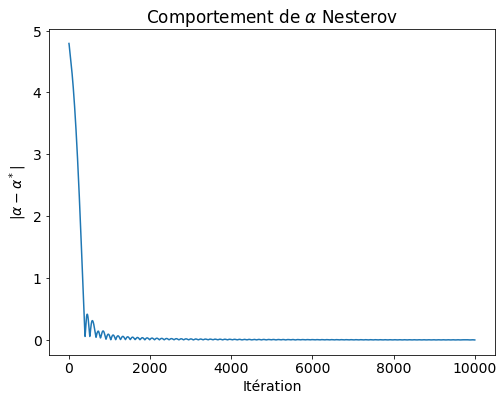

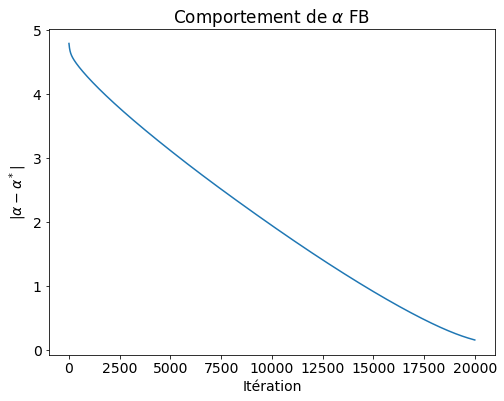

In [23]:
Nes1.comportement(alpha_star)
FB1.comportement(alpha_star)

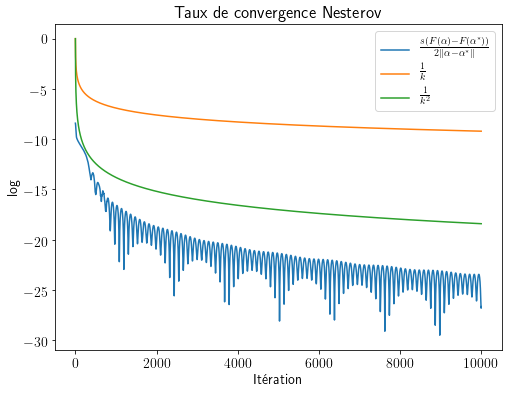

In [178]:
Nes1.CVrate(alpha_star)

(0.0, 1000.0)

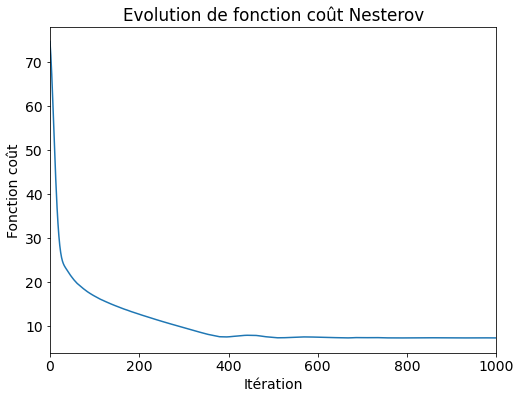

In [24]:
Nes1.plot_loss()
plt.xlim([0,1000])

On définit ci-dessous une fonction permertant comparer deux objets de ForwardBackward et de Nesterov

In [25]:
def Comparer(A, y, sigma, alpha_init, niter_max):
    '''
    FB: object of class ForwardBackward
    Nes: object of class Nesterov
    '''
    # Initialize the objects
    FB = ForwardBackward(A, y, sigma, alpha_init, niter_max)
    Nest = NesterovAcc(A, y, sigma, alpha_init, niter_max) 

    # Restore the signal
    FB.Restore()
    Nest.Restore()

    fig, axs = plt.subplots(1,3, figsize = (16,4))
    axs[0].plot(FB.loss_history, label = 'FB')
    axs[0].plot(Nest.loss_history, label = 'Nesterov')
    axs[0].set_title("Evolution de la fonction coût")
    axs[0].legend()

    axs[1].plot(FB.xtilde, label = "FB")
    axs[1].plot(Nest.xtilde, label = "Nesterov")
    axs[1].plot(x, label = "Original")
    axs[1].set_title("Comparaison des signals")
    axs[1].legend()

    axs[2].plot(x - FB.xtilde, label = "Errer de FB")
    axs[2].plot(x - Nest.xtilde, label = "Errer de Nesterov")
    axs[2].set_title("Erreurs des signals reconstruits")
    axs[2].legend()
    plt.show()
    

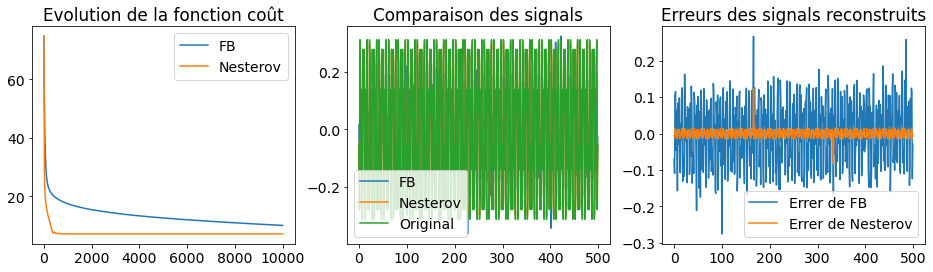

In [26]:
Comparer(A, y, sigma = 0.1, alpha_init = zeros_init, niter_max = 10000)

**Q9.** A partir de combien de mesures pouvez-vous reconstruire exactement le signal $x$ ?

**Q13.** Faites un rapide résumé des points qui vous ont semblé les plus importants dans ce TP.

## Plan d'expériences

In [27]:
import hvplot.pandas

ModuleNotFoundError: No module named 'hvplot'

In [185]:
class iteractive(param.Parameterized):
    
    list_sigma = param.Number(0.01, bounds = (0.01,2))
    list_iter = param.Integer(1000, bounds = (10000, 20000))

    def view(self):
        

SyntaxError: unexpected EOF while parsing (<ipython-input-185-f3db254cc28f>, line 7)

In [ ]:
sigma_experience = [0.1, 1, 10, 100]

fig, axs = plt.subplots(2, 2, figsize = (15,12))
for i in range(2):
    for j in range(2):
        k = 2 * i + j
        result = RestoreX(A,y,sigma_experience[k], alpha_init = zeros_init, niter_max=50000)[0][-1] 
        axs[i, j].plot(result)
        axs[i, j].set_title("sigma = "+ str(sigma_experience[k]), fontsize = 12)

for ax in axs.flat:
    ax.set_xlabel('Time', fontsize = 12)
    ax.set_ylabel('Alpha', fontsize = 12)
plt.show()